# IXO Modelling

**Objective**

Determine if there is a feasible mechanism to tie the reserve of the market maker mechanism with the reserve of the brokerage mechanism, to maintain the peg stability during the period needed to bootstrap the system. Acknowledging the discussed assumptions, incentive mechanisms, and actors, in the system - the ultimate objective is to ensure actors are incentivized to supply their assets into the system in exchange for utility so that the system can be bootstrapped effectively.

**Sprint 1 Scope**

1. Customize and parameterize the existing augmented bonding curve model developed by BlockScience
2. Determine the most suitable mechanism for tying the two reserves together (using the Kyber network and Uniswap mechanisms as inspiration)
3. Determine what parameters we have available to stabilize the market maker peg (initial assumption - use the reserve ratio, and possible exit taxation to prime this mechanism)
4. Determine if the mechanism is theoretically feasible

**Resources**

1. Augmented bonding curve hatch_sim notebook:  [https://github.com/BlockScience/conviction/blob/master/hatch_sim.ipynb](https://github.com/BlockScience/conviction/blob/master/hatch_sim.ipynb)
2. Kyber network reserve types: [https://developer.kyber.network/docs/Reserves-Types/](https://developer.kyber.network/docs/Reserves-Types/)

## IXO Liquidity Mechanism

**Uniswap notes:**

Uniswap mechanism for liquidity provider / delegators brokerage:
* Uniswap liquidity pools are autonomous and use the Constant Product Market Maker (x * y = k)
* A small liquidity provider fee (0.3%) is taken out of each trade and added to the reserves
* Formal verification: https://github.com/runtimeverification/verified-smart-contracts/blob/uniswap/uniswap/x-y-k.pdf
* The invariant is that the ratio of e:t:l is preserved and k = e * t increases (e is ether, t is exchange tokens, and l is total liquidity / supply of uni tokens)
* By supplying and burning liquidity (uni tokens), the investor can exchange for their share of ether and tokens

Uni-token === IXO staking token
If you stake you're delegating, and delegators receive a proportion of the networks fees, block rewards/inflation, service fees from oracles

**Terminology:**

* c_ - IXO-Cosmos equivalent of Ethereum tokens
* native - native to IXO-Cosmos network
* cIXOS - staking tokens 
* cIXO - utility tokens

**Actor flow:**

1. Participant buys into market maker with Dai, and is given Ethereum based IXO tokens.
2. Participant stakes IXO into the brokerage mechanism in exchange for IXOS. The IXO stake is backed by a proportion of the DAI collateral pool.
3. The IXO and IXOS pools are mirrored on the IXO-Cosmos network, and backed by DAI - post IBC these assets can be made native to the IXO-Cosmos network.
4. cIXO become utility tokens that can be spent in IXO-Cosmos network, and minted through block rewards to be rewarded to actors in the system. The utility comes from the asset backing of the cIXO tokens in the brokerage.

**Working example:**

1. Participant purchases 100 IXO tokens @ 0.1 DAI per IXO for a total of 10 DAI.
2. Participant provides liquidity in brokerage contract by depositing 50 IXO, retaining 50 IXO for the time being. The asset backing is provided by the bonding curve Dai collateral pool.
3. Participant is rewarded with 50 IXOS tokens to represent the proportion of the liquidity provided.
4. These IXOS tokens are mirrored and can be used within the IXO-Cosmos network as equivalent cIXOS tokens, these are low velocity and are essentially staked for IXO-Cosmos incentive rewards.
5. Participants within the IXO-Cosmos network, who are incentivized/rewarded with cIXO tokens for supporting the network roles, may atomic swap/mirror their cIXO tokens for IXO tokens and in effect DAI via the bonding curve.

**Observations:**

* Based on last two actions - what is the best way to couple the cIXO token value to the DAI reserve to maintain the cross blockchain peg?
* Objective - make the cIXO utility token stable.
* cIXOS staked on IXO-Cosmos side for various incentive rewards.

To reduce invariance:
* Introduce arbitrage rebalancing
* Introduce algorithmic binding
* Introduce capacitor like smoothing of binding - treat the pool like a capacitor and the variance as AC electricity, determine the RC ratio necessary to filter out noise. The smoothing capacitor acts smooths the ripple current, to an appropriate level of stability. It does this by storing charge (perhaps tax), and discharging when necessary.

### Dependancies

In [1]:
import sys
sys.path.append("../../venv/lib/python3.7/site-packages" )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from scipy.stats import expon
import math
import pickle

from cadCAD.configuration.utils import config_sim #env_trigger, var_substep_trigger, config_sim, psub_list
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import append_configs

%matplotlib inline

from helpers import *
from bonding_curve_eq import *

### Liquidity Mechanisms and Actors Overview

In [2]:
from enum import Enum, auto
class Nodes(Enum):
    POOL = auto() # Pool of specific token / collateral
    # Mechanisms
    MARKET_MAKER = auto() # Issues IXO tokens in exchange for DAI
    BROKERAGE = auto() # Issues IXOS / staking tokens to delegators
    # Actors
    SERVICE_PROVIDER = auto() # makes claims about contributions and state of project
    EVALUATOR = auto() # validates claims
    DELEGATOR = auto() # stakes into the brokerage to provide liquidity
    PARTICIPANT = auto() # generic type for any user of IXO-Cosmos utility tokens
    
class Edges(Enum):
    BALANCE = auto()
    BRIDGE = auto() # IBC style mirror
    
# IBC Ethereum Peg-Zone:
# 1. IXO from AMM and DAI staked into reserve pool by delegators in exchange for IXOS
# 2. cIXO and cIXOS matched on IXO-Cosmos network
# 3. This mechanism can be spun down, while maintaining the liquidity created, when the IBC mechanism is operational

### Global Parameters

In [3]:
liquidity_provider_fee = .03 # percent
tax = 0 # exit tax - introduces friction and possibly funds to prime stability mechanisms
theta = 0 #.35 # Funding pool taxation - 0 implies all contributions allocated to market

# From scenario spreadsheet
initial_ixo_supply = 2e9
initial_ixo_price = .02
initial_ixo_reserve = initial_ixo_supply * initial_ixo_price

founders_stake = .1 # percent
initial_ixos_supply = initial_ixo_supply * founders_stake # initial supply of staking vouchers

initial_ixo_price = .10 # average IXO price from ixo.world Euro cents
initial_ixos_price = .20 # staking voucher price from AMM in Euro cents

ixo_delegation_distribution_reserve = 1e6
ixo_delegation_distribution_supply = 1e6/initial_ixo_price #200e6 # 5 strategic delegations worth Euro 1 Mil each

# Augmented bonding curve parameters
# Hatch state
d0 = initial_ixo_reserve/1e6 # million DAI
p0 = initial_ixo_price # DAI per tokens

R0 =  d0*(1-theta) # million DAI
S0 = d0/p0

kappa = 1 # Bonding curve curvature - using an initial kappa value of 1 we can keep a constant token price for initial bootstrap phase

# Brokerage - Kyber Fed Price Reserve
# Policy to bound proposed conversion rate
sanity_rate = 10 # 1 DAI = 10 IXO
reasonable_difference = .1 # percent

# Target portfolio
# 50% DAI / 50% IXO

# Rebalancing
# Or: auto_instant - rebalance performed after every trade
time_spacing = 1 # time period after which to perform another rebalance
price_spacing_diff = .5 # percentage difference from last rebalance after which to perform another rebalance

# Pricing
maximum_spread = 0.02 # dictated by for example Kyber
minimum_spread = 0.005
spread = 0.01 # dependant on liquidity
quoted_price = 0 # TODO

# cadCAD configuration
time_steps = 24 # months, use days for more granularity

In [4]:
amm_initial_reserve, amm_initial_invariant, amm_initial_spot_price = initialize_bonding_curve(initial_ixo_supply, initial_price=initial_ixo_price, kappa=kappa, theta=theta)

In [5]:
# cadCAD Parameter Sets
#####################################################################

# amm == automated market maker
# brk == brokerage

# params = {
#     'brokerage': {
#         'sanity_rate': 10,
#         'max_spread': .02,
#     }
# }

params = {
    'sweep': [1], # for selecting parameter sweep from results
    # Automated Market Maker parameters
    'amm.kappa': [kappa],
    'amm.invariant': [amm_initial_invariant],
    'amm.tax_rate': [0],
    # Brokerage
    'brk.sanity_rate': [10], # 1 DAI = 10 IXO
    'brk.reasonable_diff': [.5], # percent
    'brk.rebalance_diff': [False], # percentage difference from last rebalance after which to perform another rebalance
    'brk.max_spread': [.02], # price
    'brk.min_spread': [.005],
    'max_delegators': [20],
    'max_validators': [20],
    'max_service_providers': [20],
    'max_participants': [60], # Sum of above
}

initial_state = {
    'amm.supply': initial_ixo_supply,
    'amm.reserve': amm_initial_reserve,
    'amm.spot_price': amm_initial_spot_price,
#     'timestamp': '2019-01-01 00:00:00'
}

### Sigmoidal Participant Base Growth

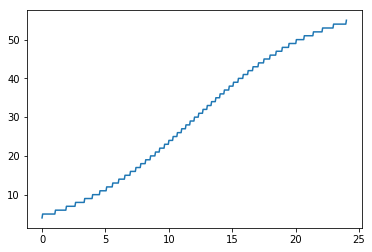

In [6]:
# Number of actors
max_delegators = 20
max_validators = 20
max_service_providers = 20
max_participants = max_delegators + max_validators + max_service_providers

# Sigmoidal growth
default_inflection = time_steps/2
default_slope = 1/5

def sigmoidal_growth(step, max_value, inflection=default_inflection, slope=default_slope):
    y = np.divide(max_value, (1 + np.power(np.e, -np.multiply(np.subtract(step, inflection), slope))))
    y = np.floor(y)
    y[y < 0] = 0
    return y

x = np.linspace(0, time_steps, 500)
y = sigmoidal_growth(x, max_participants)

plt.plot(x, y)
plt.show()

### Initialize System and Network

In [7]:
# Node generators
def add_new_pool(
        network,
        ticker):
    
    network.add_node(ticker, _type=Nodes.POOL.name)
    return network
        
def add_new_brokerage(
        network,
        _params=params,
        pair=('DAI', 'IXO')):
    
    network.add_node(generate_pair_id(pair), _type=Nodes.BROKERAGE.name)
    
    network.add_edge(generate_pair_id(pair), pair[0], _type=Edges.BALANCE.name)
    network.add_edge(generate_pair_id(pair), pair[1], _type=Edges.BALANCE.name)
    
    brokerage = {}
    brokerage['target'] = .5 # Target portfolio pair[0]:pair[1]
    brokerage['rate'] = _params['brk.sanity_rate'][0] #TODO
    brokerage['sanity_rate'] = _params['brk.sanity_rate'][0]
    brokerage['reasonable_diff'] = _params['brk.reasonable_diff'][0]
    brokerage['rebalance_diff'] = _params['brk.rebalance_diff'][0]
    brokerage['max_spread'] = _params['brk.max_spread'][0]
    brokerage['min_spread'] = _params['brk.min_spread'][0]
    
    network.nodes[generate_pair_id(pair)].update(brokerage)
    return network

def add_new_market_maker(
        network,
        _params=params,
        _initial_state=initial_state,
        pair=('DAI', 'IXO')): # Collateral -> distributed token
    
    network.add_node(generate_pair_id(pair), _type=Nodes.MARKET_MAKER.name)
    
    network.add_edge(generate_pair_id(pair), pair[0], _type=Edges.BALANCE.name)
    network.add_edge(generate_pair_id(pair), pair[1], _type=Edges.BALANCE.name)
    
    market_maker = {}
    market_maker['pair'] = pair # Reserve/collateral -> supply/token
    market_maker['reserve_type'] = pair[0]
    market_maker['supply_type'] = pair[1]
    market_maker['kappa'] = _params['amm.kappa'][0]
    market_maker['invariant'] = _params['amm.invariant'][0]
    market_maker['tax_rate'] = _params['amm.tax_rate'][0]
    market_maker['spot_price'] = _initial_state['amm.spot_price']
    
    # Initialize pools
    reserve_edge = network.edges[(generate_pair_id(pair), pair[0])]
    supply_edge = network.edges[(generate_pair_id(pair), pair[1])]
    reserve_edge['balance'] = _initial_state['amm.reserve']
    supply_edge['balance'] = _initial_state['amm.supply']
    
    network.nodes[generate_pair_id(pair)].update(market_maker)
    return network

def add_new_bridge(
        network,
        _params=params,
        pair=('IXO', 'cIXO')):
    
    network.add_edge(pair[0], pair[1], _type=Edges.BRIDGE.name)

def gen_new_participant(
        network,
        _params=params):
    
    participant = {}
    participant['key'] = 'value'
    
    return participant

def initialize_network():
    network = nx.Graph()
    color_map = []
    
    brokerage_pairs = [
        ('DAI','IXO'),
        ('cDAI','cIXO')
    ]
    
    for pair in brokerage_pairs:
        for ticker in pair:
            color_map.append('green')
            add_new_pool(network, ticker)
        color_map.append('pink')
        add_new_brokerage(network, params, pair)
        
    market_maker_pairs = [('DAI','IXO')]
    
    for pair in market_maker_pairs:
        for ticker in pair:
            color_map.append('blue')
            add_new_pool(network, ticker)
        color_map.append('pink')
        add_new_market_maker(network, params, initial_state, pair)
        
    pools = ['IXOS','cIXOS']
    
    for ticker in pools:
        color_map.append('orange')
        add_new_pool(network, ticker)
        
    bridges = [
        ('DAI', 'cDAI'),
        ('IXO', 'cIXO'),
        ('IXOS', 'cIXOS'),
    ]
    
    for pair in bridges:
        add_new_bridge(network, params, pair)
        
    return (network, color_map)

# Policies
def driving_process(_params, step, sL, s):
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participant_growth = sigmoidal_growth([s['timestep']], _params['max_participants'])[0]
    new_participants = math.ceil(participant_growth - len(participants))
    
    if new_participants:
        zipOf = zip(range(new_participants), expon.rvs(size=new_participants, loc=0.0, scale=1000))
        new_participants_collateral = dict(zipOf)
    else:
        new_participants_collateral = {}
    
    return({'new_participants': new_participants,
            'new_participants_collateral': new_participants_collateral})

def bond_process(_params, step, sL, s):
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    participants_with_collateral = filter(lambda p: network.edges[(p, 'DAI')].get('balance', 0)>0, participants)
    
    transactions = []
    for p in participants_with_collateral:
        transactions.append({
            'from': p,
            'type': 'DAI',
            'handler': ('DAI', 'IXO'),
            # Transfer all DAI collateral holdings to DAI:IXO market maker
            'value': network.edges[(p, 'DAI')]['balance'],
        })
    
    return({'transactions': transactions})

def provide_liquidity(_params, step, sL, s):
    network = s['network']
    
    participants = get_node_ids_of_type(network, Nodes.PARTICIPANT.name)
    brokers = get_node_ids_of_type(network, Nodes.BROKERAGE.name)
    participants_with_collateral = filter(lambda p: network.edges[(p, 'IXO')].get('balance', 0)>0, participants)
    
    transactions = []
    for p in participants_with_collateral:
        transactions.append({
            'from': p,
            'type': generate_pair_id(('DAI', 'IXO')),
            'handler': generate_pair_id(('DAI', 'IXO')),
            # Transfer all IXO, DAI backed collateral, holdings to brokerage
            'value': network.edges[(p, 'IXO')]['balance'],
        })
    
    return({'transactions': transactions})

def participants_decisions(params, step, sL, s):
    network = s['network']
    
    print('TODO')
    return({})

# Mechanisms for updating the state based on driving processes
def update_network(_params, step, sL, s, _input):
    network = s['network']
    
    new_participants = _input['new_participants'] # Number of
    new_participants_collateral = _input['new_participants_collateral'] # Dict
    
    for i in range(new_participants):
        index = len([node for node in network.nodes])
        network.add_node(index, _type=Nodes.PARTICIPANT.name)
        participant = gen_new_participant(network)
        network.node[index].update(participant)
        # Deposit seed collateral
        network.add_edge(index, 'DAI', balance=new_participants_collateral[i])
            
    key = 'network'
    value = network
    
    return (key, value)

def get_pool_balance(network, pool_node):
    edges = network.edges(pool_node)
    with_balance = filter(lambda edge: network.edges[edge].get('balance', 0) > 0, edges)
    balance = sum([network.edges[edge]['balance'] for edge in with_balance])
    assert(balance > 0)
    return balance

def update_balances(_params, step, sL, s, _input):
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']
    
    for tx in transactions:
        handler = network.nodes[generate_pair_id(tx['handler'])]
        handler_id = generate_pair_id(tx['handler'])
        assert(handler['_type'] == Nodes.MARKET_MAKER.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        reserve = get_pool_balance(network, handler['reserve_type'])
        supply = get_pool_balance(network, handler['supply_type'])

        if tx['type'] == reserve_pool: # Mint
            print('Mint %s' % tx['value'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaS, realized_price = mint(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            network.edges[(participant, reserve_pool)]['balance'] -= tx['value'] # DAI decrease
            if not network.has_edge(participant, supply_pool):
                network.add_edge(participant, supply_pool, balance=0)
            network.edges[(participant, supply_pool)]['balance'] += deltaS
            network.edges[(handler_id, reserve_pool)]['balance'] += tx['value']

            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        elif tx['type'] == supply_pool: # Withdraw
            print('Withdraw %s' % tx['value'])
            print(handler['kappa'])
            V0 = invariant(
                reserve,
                supply,
                handler['kappa'])
            deltaR, realized_price = withdraw(
                tx['value'],
                reserve,
                supply,
                V0,
                handler['kappa'])

            # Update holdings
            print(participant)
            network.edges[(participant, reserve_pool)]['balance'] += deltaR # DAI increase
            if not network.has_edge(participant, supply_pool):
                network.add_edge(participant, supply_pool, balance=0)
            network.edges[(participant, supply_pool)]['balance'] -= tx['value']
            network.edges[(handler_id, reserve_pool)]['balance'] -= deltaR

            # Update market maker
            handler['invariant'] = V0
            handler['spot_price'] = spot_price(
                reserve,
                handler['invariant'],
                handler['kappa'])

        else: raise # We shouldn't get here
    
    key = 'network'
    value = network
    
    return (key, value)

def update_brokerage(_params, step, sL, s, _input)
    network = s['network']
    
    # Process transactions and update balances
    # [{'from': 10, 'type': 'DAI', 'handler': ('DAI', 'IXO'), 'value': 0}]
    transactions = _input['transactions']

    for tx in transactions:
        handler = network.nodes[generate_pair_id(tx['handler'])]
        handler_id = generate_pair_id(tx['handler'])
        assert(handler['_type'] == Nodes.BROKERAGE.name)
        
        # Collateral -> token; e.g. DAI -> IXO
        participant = tx['from']
        reserve_pool = handler['reserve_type']
        supply_pool = handler['supply_type']
        reserve = get_pool_balance(network, handler['reserve_type'])
        supply = get_pool_balance(network, handler['supply_type'])
        
        if tx['type'] == generate_pair_id(reserve_pool, supply_pool): # Provide liquidity, get IXOS
            print('Provide liquidity %s' % tx['value'])
#             V0 = invariant(
#                 reserve,
#                 supply,
#                 handler['kappa'])
#             deltaS, realized_price = mint(
#                 tx['value'],
#                 reserve,
#                 supply,
#                 V0,
#                 handler['kappa'])

#             # Update holdings
#             network.edges[(participant, reserve_pool)]['balance'] -= tx['value'] # DAI decrease
#             if not network.has_edge(participant, supply_pool):
#                 network.add_edge(participant, supply_pool, balance=0)
#             network.edges[(participant, supply_pool)]['balance'] += deltaS
#             network.edges[(handler_id, reserve_pool)]['balance'] += tx['value']

#             # Update market maker
#             handler['invariant'] = V0
#             handler['spot_price'] = spot_price(
#                 reserve,
#                 handler['invariant'],
#                 handler['kappa'])
        
        elif tx['type'] == reserve_pool: # Swap reserve (DAI) for tokens (IXO)
            
        elif tx['type'] == supply_pool: # Swap tokens for reserve
        
        else: raise # We shouldn't get here
        
    key = 'network'
    value = network
    
    return (key, value)


### Brokerage framework / liquidity provision

In [10]:
# Brokerage framework / liquidity provision (see Uniswap/Kyber)
# https://github.com/runtimeverification/verified-smart-contracts/blob/uniswap/uniswap/x-y-k.pdf

def add_liquidity(tokens, value):
    reserve_balance = 0 # e.g. DAI
    token_balance = 0 # e.g. IXO
    liquidity_token_balance = 0 # e.g. IXOS
    
    alpha = value/reserve
    
    new_reserve = (1 + alpha)*reserve_balance
    new_tokens = (1 + alpha)*token_balance
    new_liquidity_tokens = (1 + alpha)*liquidity_token_balance
    
    return False

def remove_liquidity(liquidity_tokens):
    reserve_balance = 0 # e.g. DAI
    token_balance = 0 # e.g. IXO
    liquidity_token_balance = 0 # e.g. IXOS
    
    alpha = liquidity_tokens/liquidity_token_balance
    
    new_reserve = (1 - alpha)*reserve_balance
    new_tokens = (1 - alpha)*token_balance
    new_liquidity_tokens = (1 - alpha)*liquidity_token_balance
    
    return False

def get_input_price(dx):
    x_balance = 0
    y_balance = 0
    rho = 0 # trade fee
    
    alpha = dx/x_balance
    gamma = 1 - rho
    
    new_x = (1 + alpha)*x_balance
    new_y = (1 / (1 + alpha*gamma))*y_balance
    
    input_price = (alpha*gamma / (1 + alpha*gamma))*y_balance
    
    return False

def get_output_price(dy):
    
    
    
    return False

# Token trading
def collateralToToken():
    return False

def tokenToCollateral():
    return False

def tokenToToken():
    return False

### Configure cadCAD

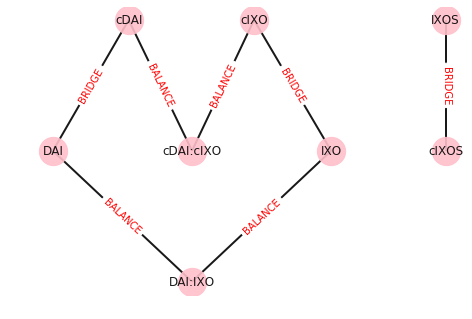

In [34]:
# cadCAD Initial State
#####################################################################
network, color_map = initialize_network()
pos = nx.drawing.nx_agraph.graphviz_layout(network, prog='dot') #spring_layout(network, k=0.15,iterations=20)

plt.figure()
nx.draw(
    network, pos, edge_color='black', width=2, linewidths=1,
    node_size=800, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

#nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True)

initial_state.update({
    'network': network,
})

In [9]:
runs = 1 # Monte Carlo runs

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': runs,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 24),
  'M': {'sweep': 1,
   'amm.kappa': 1,
   'amm.invariant': 10.0,
   'amm.tax_rate': 0,
   'brk.sanity_rate': 10,
   'brk.reasonable_diff': 0.5,
   'brk.rebalance_diff': False,
   'brk.max_spread': 0.02,
   'brk.min_spread': 0.005,
   'max_delegators': 20,
   'max_validators': 20,
   'max_service_providers': 20,
   'max_participants': 60}}]

### Perform Simulation

In [11]:
# ts_format = '%Y-%m-%d %H:%M:%S'
# t_delta = timedelta(days=30, minutes=0, seconds=0)
# def time_model(_g, step, sL, s, _input):
#     y = 'time'
#     x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
#     return (y, x)

# exogenous_states = {
# #     'time': time_model
# }
# env_processes = {}

partial_state_update_blocks = [
    { # Generate new participants
        'policies': {
            'generate': driving_process,
        },
        'variables': {
            'network': update_network,
        }
    },
    {
        'policies': {
            'bond': bond_process,
        },
        'variables': {
            'network': update_balances,
        }
    },
    { # Participants provide liquidity via brokerage
        'policies': {
            'provide': provide_liquidity,
        },
        'variables': {
            'network': update_brokerage,
        }
    },
#     { # Brokerage rebalance
#         'policies': {
#             'rebalance': brokerage_rebalance,
#         },
#         'variables': {
#             'network': update_brokerage,
#         }
#     },
    #TODO: sync bridges
#     { # Accounting
#         'policies': {
#             'participants_act': participants_decisions,
#         },
#         'variables': {
#             'network': update_holdings,
#             'amm.supply': update_supply,
#             'amm.reserve': update_reserve,
#             'amm.spot_price': update_price,
#         }
#     }
]

In [12]:
append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

sys.setrecursionlimit(10000)
from cadCAD import configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

[{'N': 1, 'T': range(0, 24), 'M': {'sweep': 1, 'amm.kappa': 1, 'amm.invariant': 10.0, 'amm.tax_rate': 0, 'brk.sanity_rate': 10, 'brk.reasonable_diff': 0.5, 'brk.rebalance_diff': False, 'brk.max_spread': 0.02, 'brk.min_spread': 0.005, 'max_delegators': 20, 'max_validators': 20, 'max_service_providers': 20, 'max_participants': 60}}]

                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f80291be0b8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f80291be0b8>]
0
Mint 1958.176970443639
Mint 114.77066246750434
Mint 1204.3509045614264
Mint 447.84813970998977
4
Mint 1222.9990708411335
5
Mint 51.74528111790875
Mint 2093.656130966631
7
Mint 459.08213698326915
8
Mint 1817.3009148382337
Min

# Model Data Analysis

In [13]:
# Choose which experiment parameter configuration to use, integer starting from zero
import os

def select_experiment(results, i):
    df = pd.DataFrame(results[i - 1]['result'])
    directory = './experiment_%s/' % i
    if not os.path.exists(directory):
        os.makedirs(directory)
    return df[df.substep==len(partial_state_update_blocks)].copy()

def save_experiment(fig, experiment, name):
    pickle.dump(fig, open('experiment_%s/%s.pickle' % (experiment, name), 'wb'))
    fig.savefig('experiment_%s/%s.png' % (experiment, name))

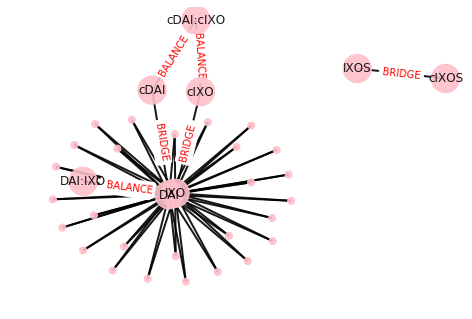

In [33]:
rdf = select_experiment(results, 1)
network_output = rdf['network'][24]

pos = nx.drawing.nx_agraph.graphviz_layout(network_output, prog='neato') #spring_layout(network, k=0.15,iterations=20)

node_sizes = [50 if network_output.nodes[node]['_type'] == Nodes.PARTICIPANT.name else 800 for node in network_output.nodes()]

plt.figure()
nx.draw(
    network_output, pos, edge_color='black', width=2, linewidths=1,
    node_size=node_sizes, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network_output, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

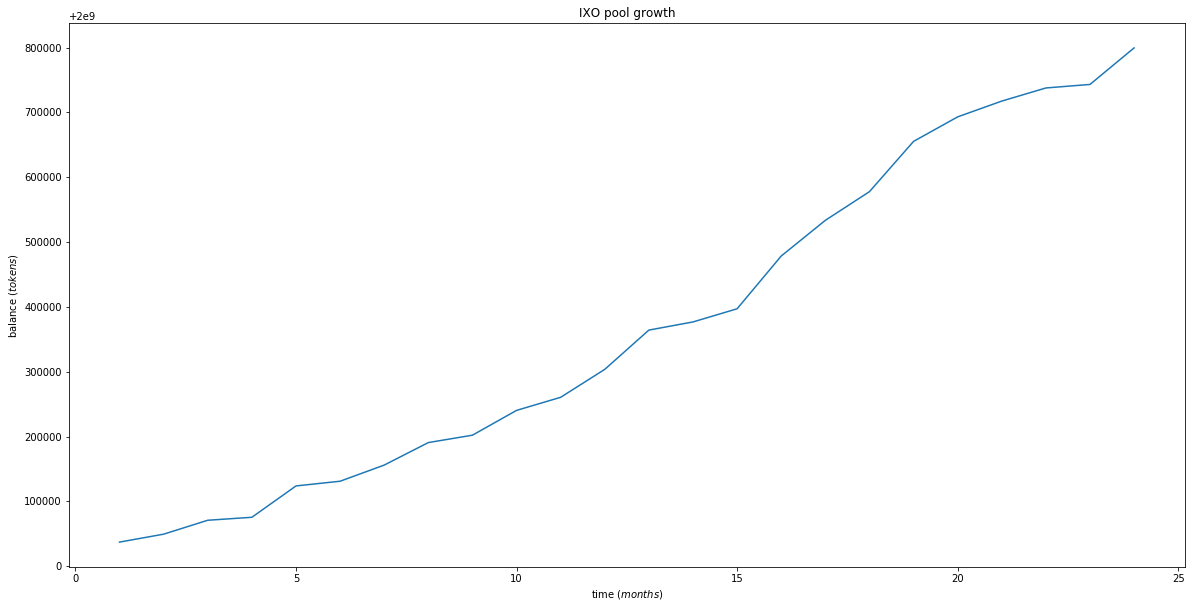

In [38]:
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['IXO_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'IXO'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf['IXO_pool_growth'])
    plt.title('IXO pool growth')
    plt.xlabel('time ($months$)')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, 'IXO_pool_growth')

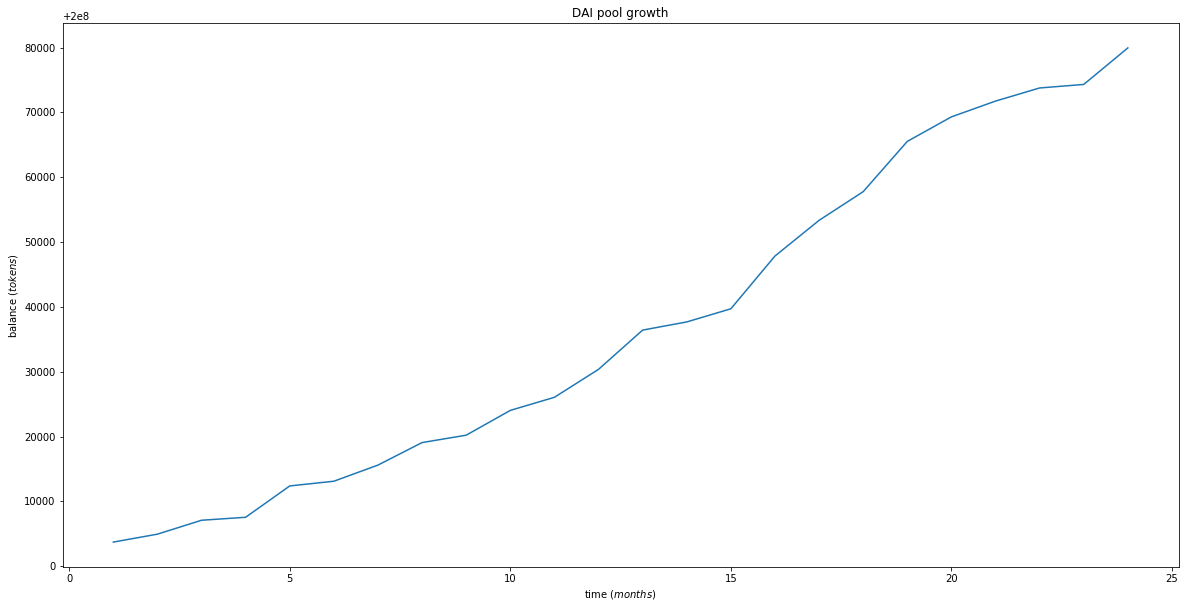

In [39]:

    
for experiment in params['sweep']:
    rdf = select_experiment(results, experiment)
    rdf['DAI_pool_growth'] = rdf['network'].apply(lambda g: get_pool_balance(g, 'DAI'))

    fig = plt.figure(1,figsize=(20,10))
    #data = make2D('IXO_pool_growth', rdf)
    plt.plot(rdf.timestep, rdf['DAI_pool_growth'])
    plt.title('DAI pool growth')
    plt.xlabel('time ($months$)')
    plt.ylabel('balance ($tokens$)')

    save_experiment(fig, experiment, 'IXO_pool_growth')

## Augumented bonding curve Mathematics

### Hatch Sale Equations

- Initial Raise $d_0$ Dai
- Initial Reserve is $R_0 = (1-\theta) d_0$
- Hatch sale Price $p_0$ (dai per token) determines the initial supply: $S_0 = d_0/p_0$
- Power Function Invariant shape: $V(R, S) = \frac{S^\kappa}{R}$
- Price function (DAI per Token): $P(R) = \frac{\kappa R^{(\kappa-1)/ \kappa}}{V_0^{1 / \kappa}}$
- Supply function (tokens): $S(R) = \sqrt[\kappa]{V_0 R}$
- Reserve function (xDAI): $R(S) = \frac{S^{\kappa}}{V_0} $
- The invariant coef: $V_0 = V(R_0, S_0) = \frac{S_0^\kappa}{R_0} = \left(\frac{1}{p_0(1-\theta)}\right)^\kappa R_0^{\kappa-1}$
- The post hatch price: $p_1=P(R_0) = \frac{\kappa R_0^{(\kappa-1)/ \kappa}}{V_0^{1 / \kappa}} = \kappa R_0^{(\kappa-1)/ \kappa} \cdot(1-\theta)p_0\cdot R_0^{-(\kappa-1)/\kappa} = \kappa(1-\theta) p_0$
- The Return factor: $\frac{p_1}{p_0} = {\kappa}(1-\theta)$

### Invariant Preserving Deposit-to-Mint
 - Deposit $\Delta R$ xdai 
 - Conservation equation: $V(R+ \Delta R, S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R} =V_0$
 - Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= \sqrt[\kappa]{V_0(R+\Delta R)}-S$
 - Realized Price is: $\bar{P}(\Delta R) =\frac{\Delta R}{\Delta S} = \frac{\Delta R}{\sqrt[\kappa]{V_0(R+\Delta R)}-\sqrt[\kappa]{V_0(R)}} \rightarrow \big(\frac{\partial S(R)}{\partial R} \big)^{-1}$ as $\Delta R \rightarrow 0$
 - The limiting price is the spot price: $\lim_{\Delta R \rightarrow 0} \bar{P}(\Delta R)=\big(\frac{\partial S(R)}{\partial R}\big)^{-1}= \big(\frac{V_0^{1/\kappa} \cdot  R^{1/\kappa-1}}{\kappa}\big)^{-1}= \frac{\kappa R^{1-1/\kappa}}{V_0^{1/\kappa}} = \frac{\kappa R^{(\kappa-1)/\kappa}}{V_0^{1/\kappa}} =P(R)$
 
### Invariant Preserving Burn-to-Withdraw
 - Burn $\Delta S$ tokens
 - Conservation equation: $V(R- \Delta R, S-\Delta S) = \frac{(S-\Delta S)^\kappa}{R-\Delta R} =V_0$
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R-\frac{(S-\Delta S)^\kappa}{V_0}$
 - Realized Price is: $\bar{P}(\Delta S) =\frac{\Delta R}{\Delta S} = \frac{\frac{S^{\kappa}}{V_0}-\frac{(S-\Delta S)^\kappa}{V_0}}{\Delta S} \rightarrow \frac{\partial R(S)}{\partial S} $ as $\Delta S \rightarrow 0$
 - The limiting price is the spot price: $\lim_{\Delta S \rightarrow 0} \bar{P}(\Delta S)=\frac{\partial R(S)}{\partial S}=\frac{\kappa S^{\kappa-1}}{V_0} = \frac{\kappa \cdot (\sqrt[\kappa]{V_0 R})^{\kappa-1}}{V_0}= \frac{\kappa R^{(\kappa-1)/\kappa}}{V_0^{1/\kappa}}=P(R)$
 - Given friction coef $\phi$ 
     - sent to burning agent address: $\Delta R_{agent} = (1-\phi) \Delta R$
     - sent to the funding pool address: $\Delta R_{pool} = \phi \Delta R$
     - due to the friction the true realized price for the agent is $(1-\phi)\cdot \bar{P}(\Delta S)$
     - due to the friction the true return factor post withdraw is: ${\kappa}(1-\theta)(1-\phi)$

## Bonding curve parameter analysis

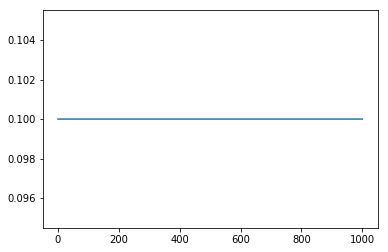

In [16]:
V0 = invariant(R0,S0,kappa)

reserve = np.arange(0,100,.01)
supp = np.array([supply(r, V0, kappa) for r in reserve])
price = np.array([spot_price(r, V0, kappa) for r in reserve])

fig, axs = plt.subplots()

axs.plot(supp, price)

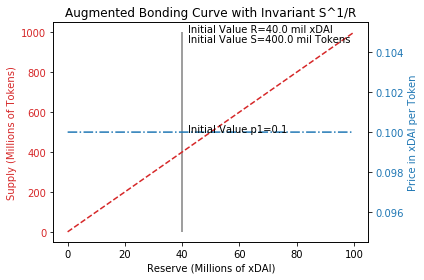

In [17]:
V0 = invariant(R0,S0,kappa)

reserve = np.arange(0,100,.01)
supp = np.array([supply(r, V0, kappa) for r in reserve])
price = np.array([spot_price(r, V0, kappa) for r in reserve])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Reserve (Millions of xDAI)')
ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
ax1.plot(reserve, supp,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(reserve, price,'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(R0,0,supp[-1], alpha=.5)
ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(S0)+" mil Tokens")
#ax1.hlines(S0,0,R0)

ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(100*spot_price(R0,V0,kappa))/100))


plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

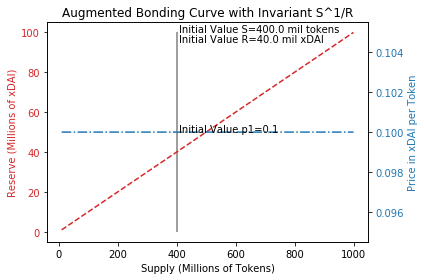

In [18]:
fig, ax1 = plt.subplots()

cp = 100
color = 'tab:red'
ax1.set_xlabel('Supply (Millions of Tokens)')
ax1.set_ylabel('Reserve (Millions of xDAI)', color=color)
ax1.plot(supp[cp:], reserve[cp:],'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(supp[cp:], price[cp:],'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(S0,0,reserve[-1], alpha=.5)
ax1.text(S0*1.02, reserve[-1], "Initial Value S="+str(int(100*S0)/100)+" mil tokens")
ax1.text(S0*1.02, .95*reserve[-1], "Initial Value R="+str(R0)+" mil xDAI")
#ax1.hlines(S0,0,R0)

ax2.text(S0*1.02, price[3], "Initial Value p1="+str(int(100*spot_price(R0,V0,kappa))/100))


plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [19]:
#given V0 and kappa
#sweep the reserve
reserve = None
reserve = np.arange(.01,100,.01)
price = np.array([spot_price(r,V0,kappa) for r in reserve])

#realized price for withdrawing burning .1% of tokens
withdraw_price=[withdraw(supply(r,V0,kappa)/1000, r,supply(r,V0,kappa), V0, kappa)[1] for r in reserve]

#realized price for depositing .1% more Xdai into the reserve
mint_price=[mint(r/1000, r, supply(r,V0,kappa), V0, kappa)[1] for r in reserve]

In [20]:
pdf = pd.DataFrame({'reserve':reserve, 'spot_price':price, '.1% mint_price':mint_price,'.1% withdraw_price':withdraw_price })

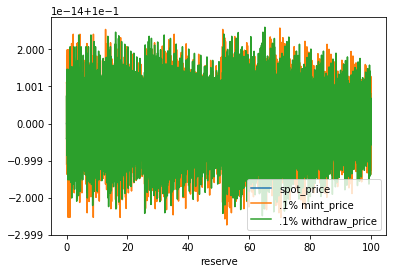

In [21]:
pdf.plot(x='reserve')

In [22]:
pdf['mint_slippage'] = (pdf['.1% mint_price']-pdf['spot_price'])/pdf['spot_price']
pdf['withdraw_slippage'] = (pdf['spot_price']-pdf['.1% withdraw_price'])/pdf['spot_price']

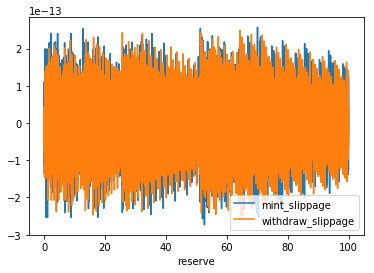

In [23]:
pdf.plot(x='reserve', y = ['mint_slippage', 'withdraw_slippage'])#, logy=True)

In [24]:
#given V0 and kappa
R = 20
S = supply(R,V0,kappa)
p = spot_price(R,V0,kappa)
#sweep the transaction fraction
TXF = np.logspace(-6, 0, num=1000)

#realized price for withdrawing burning .1% of tokens
withdraw_price2=[withdraw(S*txf, R,S, V0, kappa)[1] for txf in TXF]

#realized price for depositing .1% more Xdai into the reserve
mint_price2=[mint(R*txf, R,S, V0, kappa)[1] for txf in TXF]

In [25]:
print(S)

200.0


In [26]:
pdf2 = pd.DataFrame({'tx_fraction':TXF, 'spot_price':p*np.ones(len(TXF)), 'mint_price':mint_price2,'withdraw_price':withdraw_price2 })

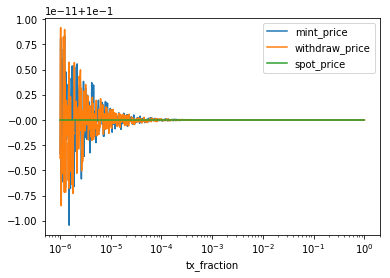

In [27]:
pdf2.plot(x='tx_fraction',y=['mint_price','withdraw_price','spot_price'], logx=True)

In [28]:
pdf2['mint_slippage'] = (pdf2['mint_price']-pdf2['spot_price'])/pdf2['spot_price']
pdf2['withdraw_slippage'] = (pdf2['spot_price']-pdf2['withdraw_price'])/pdf2['spot_price']

Text(0.5, 0, 'Transaction size as percent of the asset Burned or Bonded')

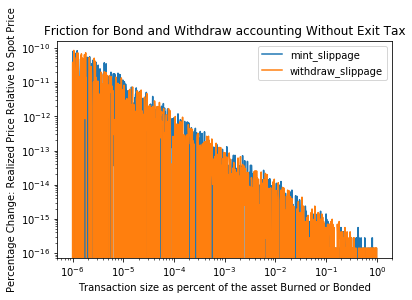

In [29]:
pdf2.plot(x='tx_fraction', y = ['mint_slippage', 'withdraw_slippage'], logx=True, logy=True)
plt.title("Friction for Bond and Withdraw accounting Without Exit Tax")
plt.ylabel("Percentage Change: Realized Price Relative to Spot Price")
plt.xlabel("Transaction size as percent of the asset Burned or Bonded")

In [30]:
pdf2['withdraw_slippage_with_tax'] = pdf2['withdraw_slippage']+tax

Text(0.5, 0, 'Transaction size as percent of the asset Burned or Bonded')

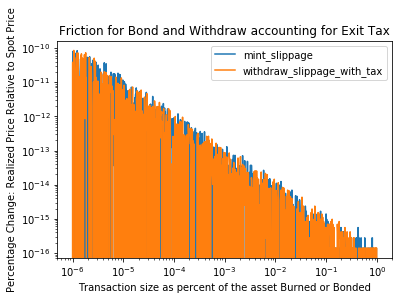

In [31]:
pdf2.plot(x='tx_fraction', y = ['mint_slippage', 'withdraw_slippage_with_tax'], logx=True, logy=True)
plt.title("Friction for Bond and Withdraw accounting for Exit Tax")
plt.ylabel("Percentage Change: Realized Price Relative to Spot Price")
plt.xlabel("Transaction size as percent of the asset Burned or Bonded")

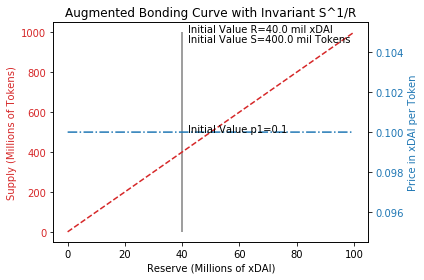

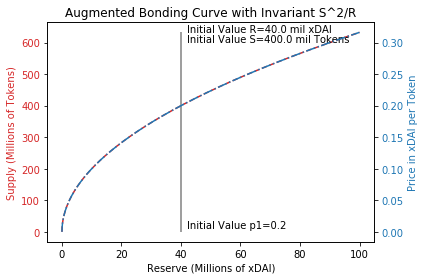

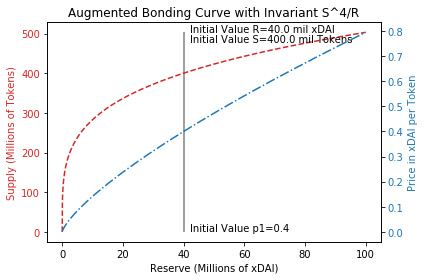

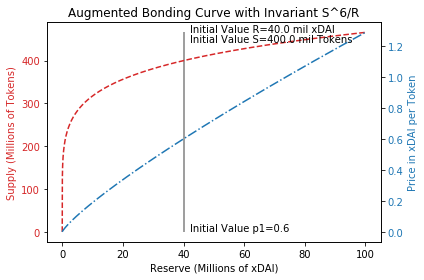

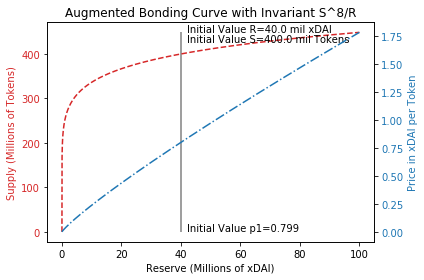

In [32]:
Kappa_List = [1,2,4,6,8]
for kappa in Kappa_List:
    
    V0 = invariant(R0,S0,kappa)
    
    reserve = np.arange(0,100,.01)
    supp = np.array([supply(r, V0, kappa) for r in reserve])
    price = np.array([spot_price(r, V0, kappa) for r in reserve])

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Reserve (Millions of xDAI)')
    ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
    ax1.plot(reserve, supp,'--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
    ax2.plot(reserve, price,'-.', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.vlines(R0,0,supp[-1], alpha=.5)
    ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
    ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(int(100*S0)/100)+" mil Tokens")
    #ax1.hlines(S0,0,R0)

    ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(1000*spot_price(R0,V0,kappa))/1000))


    plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()